# Crawl Data Analysis: Clustering v2 (using text + location features)

This notebook experiments with clustering using both text and location features of the data. It should be run on cycles - see `clustering.ipynb` for a reference of how to set this up. It's written for Python 2.7 and uses several packages (see `import` statements).

**Key idea.** Intuitively, we think it would make sense to incorporate location features (e.g. x, y of segments, is it in a popup dialog?, etc). We distill these to the following binary features:

- Is this segment in a popup?
- Is this segment in the:
    - x: left, middle, or right of the page
    - y: top, middle, or bottom of the page
    
We use much of the logic from `dismiss_dialog.js` to determine whether a segment is in a popup, and we break the page into 3 sections in the x/y dimensions and place it in one of these "bins". e.g. A segment that's in the "main" content (center of the page) and not in a popup might have the representation: (0, 0, 1, 0, 0, 1, 0), where each feature is (popup, x_left, x_middle, x_right, y_top, y_middle, y_bottom).

In [121]:
from __future__ import print_function
from tqdm import tqdm
import numpy as np
import os
import pandas as pd

## Read from database and build feature matrix

Preprocessing:

- Lower case (but add an indicator for whether there were all-caps words)
- Replace numbers with a placeholder
- Remove uninteresting punctuation (e.g. keep exclamation points, but get rid of periods)
- Remove excess whitespace
- Remove "stop words"
- Stem words (via Porter's stemming algorithm)

Feature representation: bag-of-words (each feature is an indicator for a word) + indicator for whether the text contained all-caps words + the location features described above.

In [122]:
from nltk.stem.porter import PorterStemmer
import nltk
import re
import string

nltk.download('stopwords')

stemmer = PorterStemmer()
stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = re.sub(r'[!$*%-?]', '', string.punctuation)
stopwords = stopwords.union(set(punctuation))

# Returns preprocessed version of the string s, as well as an indicator (0 or 1)
# for whether s contained any all-caps words
def preprocess(s):
    s = re.sub(r'[%s]+' % string.whitespace, ' ', s)
    
    caps = 0
    words = s.split()
    for word in words:
        if word.isupper():
            caps = 1
            break
    
    s = s.lower()
    s = re.sub(r'\d+', 'dpnum', s)
    s = re.sub(r'[^a-z\s]', '', s)
    words = s.split()
    words = [stemmer.stem(w) for w in words if len(w) > 0 and w not in stopwords]
    
    # Get rid of suffixes on numbers (e.g. units) and merge multiple numbers
    # in one word together
    for i in range(len(words)):
        if words[i].startswith('dpnum'):
            words[i] = 'dpnum'
    
    return ' '.join(words), caps

# Sanity check
s = '''Color   
Choose an option
Silver
Space Gray

Size    
Choose an option
64 gb

BUY NOW'''
print('ORIGINAL STRING:')
print(s)
print()
print('RESULT OF PREPROCESSING:')
print(preprocess(s))

[nltk_data] Downloading package stopwords to /u/mjf4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ORIGINAL STRING:
Color   
Choose an option
Silver
Space Gray

Size    
Choose an option
64 gb

BUY NOW

RESULT OF PREPROCESSING:
(u'color choos option silver space gray size choos option dpnum gb buy', 1)


Iterate through data, storing text-based features as well as additional columns, which we'll use to compute the extra features next.

(Note that as we read data, we track the max values for `top` (y) and `left` (x) to estimate the height and width of each site, since we don't have the actual values.)

In [123]:
from collections import defaultdict
from scipy import sparse
from sklearn.feature_extraction.text import HashingVectorizer
from tqdm import tqdm
import json
import sqlite3

db = '/n/fs/darkpatterns/crawl/2018-12-08_segmentation_pilot2/2018-12-08_segmentation_pilot2.sqlite'
con = sqlite3.connect(db)
con.row_factory = sqlite3.Row
cur = con.cursor()

query = """select * from
    segments as sg left join site_visits as sv on sv.visit_id = sg.visit_id
    where lower(sg.node_name) <> 'body' and sg.inner_text <> ''
"""

hv = HashingVectorizer(n_features=2**18, strip_accents='ascii', alternate_sign=False)
text_fts = None
extra_fts = None
text_fts_tmp_list = []
extra_fts_tmp_list = []
widths = defaultdict(lambda: 0)
heights = defaultdict(lambda: 0)
count = 0
for segment in tqdm(cur.execute(query)):
    text_proc, caps = preprocess(segment['inner_text'])

    if count == 0:
        print('Columns:\n%s' % '\n'.join(['%s (%s)' % (c, str(type(segment[c]))) for c in segment.keys()]))
    
    # Store extra features
    try:
        style = json.loads(segment['style'])
        extra_fts_tmp_list.append(np.array([segment['site_url'], caps, style['display'],
            style['visibility'], style['position'], segment['left'], segment['top'],
            style['z-index']]).reshape(1, 8))
    except:
        continue
        
    # Update width/height of this page
    url = segment['site_url']
    x = segment['left']
    y = segment['top']
    if x > widths[url]:
        widths[url] = x
    if y > heights[url]:
        heights[url] = y
        
    # Compute text features
    fts = hv.fit_transform([text_proc])
    text_fts_tmp_list.append(fts)
    
    if count % 25000 == 0:
        if count == 0:
            text_fts = text_fts_tmp_list[0]
            extra_fts = extra_fts_tmp_list[0]
        else:
            text_fts = sparse.vstack([text_fts] + text_fts_tmp_list)
            extra_fts = np.vstack([extra_fts] + extra_fts_tmp_list)
        text_fts_tmp_list = []
        extra_fts_tmp_list = []
    count += 1
    
text_fts = sparse.vstack([text_fts] + text_fts_tmp_list)
extra_fts = np.vstack([extra_fts] + extra_fts_tmp_list)

36it [00:00, 175.82it/s]

Columns:
id (<type 'int'>)
crawl_id (<type 'int'>)
visit_id (<type 'int'>)
node_name (<type 'unicode'>)
node_id (<type 'int'>)
top (<type 'int'>)
left (<type 'int'>)
width (<type 'int'>)
height (<type 'int'>)
style (<type 'unicode'>)
inner_text (<type 'unicode'>)
outer_html (<type 'unicode'>)
longest_text (<type 'unicode'>)
longest_text_width (<type 'int'>)
longest_text_height (<type 'int'>)
longest_text_top (<type 'int'>)
longest_text_left (<type 'int'>)
longest_text_style (<type 'unicode'>)
num_buttons (<type 'int'>)
num_imgs (<type 'int'>)
num_anchors (<type 'unicode'>)
time_stamp (<type 'unicode'>)
visit_id (<type 'int'>)
crawl_id (<type 'int'>)
site_url (<type 'unicode'>)


740532it [16:30, 747.92it/s] 


In [ ]:
# from sklearn.feature_extraction.text import TfidfTransformer

# text_fts_tfidf = TfidfTransformer().fit_transform(text_fts)

In [181]:
print('text features matrix: %s (%s)' % (str(text_fts.shape), str(text_fts.dtype)))
print('extra features matrix: %s (%s)' % (str(extra_fts.shape), str(extra_fts.dtype)))

text features matrix: (740532, 262144) (float64)
extra features matrix: (740532, 8) (<U478)


Compute the additional features.

In [135]:
# Returns indicator (0 or 1)
def is_in_popup(row, widths, heights):
    display = (row[2] != 'none')
    visibility = (row[3] == 'visible')
    position = (row[4] != 'static')
    zindex = row[7]
    
    # Check if segment is roughly in the center of the page
    url = row[0]
    x = int(row[5])
    y = int(row[6])
    x_center = widths[url] / 2.0
    y_center = heights[url] / 2.0
    thresh = 0.3
    if np.abs(x - x_center) / widths[url] < thresh and np.abs(y - y_center) / heights[url] < thresh:
        in_center = True
    else:
        in_center = False

    if display and visibility and position and (zindex != 'auto') and (zindex > 0) and in_center:
        return 1
    return 0

In [136]:
# Returns three indicators (0 or 1) for whether this segment is in the
# left, middle, or right section of the page
def compute_x_fts(row, widths):
    url = row[0]
    x = int(row[5])
    width = widths[url]
    if x < 0.2 * width:
        return 1, 0, 0
    elif x > 0.8 * width:
        return 0, 0, 1
    else:
        return 0, 1, 0

# Analogous for top, middle, bottom sections
def compute_y_fts(row, widths):
    url = row[0]
    y = int(row[6])
    height = heights[url]
    if y < 0.1 * height:
        return 1, 0, 0
    elif y > 0.9 * height:
        return 0, 0, 1
    else:
        return 0, 1, 0

In [137]:
urls = np.matrix(extra_fts[:,0]).T

x_fts = np.matrix([compute_x_fts(row, widths) for row in extra_fts])
y_fts = np.matrix([compute_y_fts(row, heights) for row in extra_fts])
popup_fts = np.matrix([is_in_popup(row, widths, heights) for row in extra_fts]).T

caps_fts = np.matrix([int(row) for row in extra_fts[:,1]]).T

/n/fs/ugrad/ug19/mjf4/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/n/fs/ugrad/ug19/mjf4/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [183]:
matrices = [('text_fts', text_fts), ('urls', urls), ('x_fts', x_fts), ('y_fts', y_fts),
    ('popup_fts', popup_fts), ('caps_fts', caps_fts)]
for name, m in matrices:
    print('%s matrix: %s (%s)' % (name, str(m.shape), str(m.dtype)))

text_fts matrix: (740532, 262144) (float64)
urls matrix: (740532, 1) (<U478)
x_fts matrix: (740532, 3) (int64)
y_fts matrix: (740532, 3) (int64)
popup_fts matrix: (740532, 1) (int64)
caps_fts matrix: (740532, 1) (int64)


## Experiment 1: Text + location features -> PCA

On the *reduced dataset*, try adding the location features to the bag-of-words text features. Then apply PCA and compare the PCs. Do these new features add enough variance to be accounted for in the PCs? If so, we can try proceeding with clustering and see the results.

In [139]:
fts = sparse.hstack([text_fts, caps_fts, popup_fts, x_fts, y_fts])

Verify that the columns have been added properly - there should be 8 extra columns in addition to text features.

In [140]:
print('text features matrix: %s (%s)' % (str(text_fts.shape), str(text_fts.dtype)))
print('features matrix: %s (%s)' % (str(fts.shape), str(fts.dtype)))

text features matrix: (740532, 262144) (float64)
features matrix: (740532, 262152) (float64)


Now do PCA with and without the new features.

In [141]:
from sklearn.decomposition import TruncatedSVD
from scipy import stats

print('Computing SVD with additional features...')
svd_extra = TruncatedSVD(n_components=200, random_state=13)
svd_extra.fit(fts)

print('Computing SVD without additional features...')
fts_no_extra = sparse.hstack([fts.tocsc()[:,:-8], np.zeros((fts.shape[0], 8))])
svd_no_extra = TruncatedSVD(n_components=200, random_state=13)
svd_no_extra.fit(fts_no_extra)

Computing SVD with additional features...
Computing SVD without additional features...


TruncatedSVD(algorithm='randomized', n_components=200, n_iter=5,
       random_state=13, tol=0.0)

In [142]:
print('Matrix of PCs (should be same size): %s vs %s' % (str(svd_extra.components_.shape), str(svd_no_extra.components_.shape)))

Matrix of PCs (should be same size): (200, 262152) vs (200, 262152)


Now that we have the PCs for both sets of data (with the new features and without), we'll compare *cosine angles* between the two sets of PCs to get a sense of how similar or different they are.

In [146]:
from scipy.spatial.distance import cosine

ncomps = svd_extra.components_.shape[0]
cosines = [cosine(svd_extra.components_[i], svd_no_extra.components_[i]) for i in range(ncomps)]
pd.Series(cosines).describe()

count    200.000000
mean       1.004655
std        0.054193
min        0.658319
25%        0.987769
50%        1.006368
75%        1.030209
max        1.127439
dtype: float64

So based on this, we conclude that adding these new features doesn't change the PCs very much at all (cosine similarities are hovering tightly around 1), so:
1. The variance in the data is dominated by the text features (as we would expect, since they account for $2^{18}$ of the features)
2. It's not worth clustering on this particular feature representation.

## Experiment 2: Text features -> PCA -> + location features

Alternatively, we can add these new features after applying PCA to the text features *alone*. Thus we would get a concise representation of the text, and the new features could contribute a larger share of the information in the data.

Choose a reasonable number of components to use based on the amount of variance captured.

In [197]:
max_comps = 200
svd = TruncatedSVD(n_components=max_comps, random_state=13)
svd.fit(text_fts)

variances = []
ncomps = np.hstack([np.arange(5, max_comps, 10), max_comps])
for n in ncomps:
    variances.append(np.sum(svd.explained_variance_ratio_[:n]))

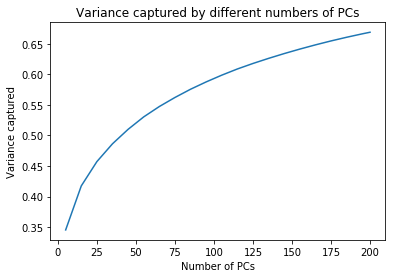

In [203]:
import matplotlib.pyplot as plt

plt.plot(ncomps, variances)
plt.title('Variance captured by different numbers of PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Variance captured')

Based on this, we choose 25 components to capture ~45% of variance (we could choose more, but then clustering will become prohibitively computationally expensive, and for a relatively small increase in captured variance).

In [204]:
n = 25
svd = TruncatedSVD(n_components=n, random_state=13)
fts_reduced = svd.fit_transform(text_fts)
print('Reduced text features matrix: %s' % str(fts_reduced.shape))
print('Captured variace: %.5f' % np.sum(svd.explained_variance_ratio_[:n]))

Reduced text features matrix: (740532, 25)
Captured variace: 0.45692


In [205]:
fts = np.hstack([fts_reduced, caps_fts, popup_fts, x_fts, y_fts])

In [206]:
print('Features matrix (should have 8 more features than fts_reduced): %s (%s)' % (str(fts.shape), str(fts.dtype)))

Features matrix (should have 8 more features than fts_reduced): (740532, 33) (float64)


Let's just inspect each feature to get a sense of their scale - before we cluster, we want to be sure that the extra features don't get proportionally more/less weight because of their scale.

In [208]:
print('Distribution of a sample of text features:')
subset_idxs = np.random.choice(np.arange(fts.shape[1] - 8), size=5, replace=False)
for i in subset_idxs:
    s = pd.Series(np.ravel(fts[:,i])).describe()
    print(str(s), '\n')
    
print('Distribution of nontext features:')
for i in range(fts.shape[1] - 8, fts.shape[1]):
    s = pd.Series(np.ravel(fts[:,i])).describe()
    print(str(s), '\n')

Distribution of a sample of text features:
count    7.405320e+05
mean     6.310706e-03
std      6.694556e-02
min     -2.206938e-01
25%     -4.967303e-07
50%      4.271657e-04
75%      1.144370e-03
max      8.776565e-01
dtype: float64 

count    740532.000000
mean          0.003133
std           0.061726
min          -0.137357
25%          -0.006045
50%          -0.000018
75%           0.000233
max           0.965284
dtype: float64 

count    740532.000000
mean         -0.001177
std           0.063958
min          -0.530326
25%          -0.001162
50%          -0.000317
75%           0.000001
max           0.780548
dtype: float64 

count    740532.000000
mean          0.005038
std           0.055972
min          -0.133492
25%          -0.001603
50%           0.000000
75%           0.001421
max           0.931569
dtype: float64 

count    740532.000000
mean          0.007228
std           0.073023
min          -0.026995
25%          -0.003031
50%          -0.000000
75%           0.000972


Looks like the range of values of the text features is roughly between -1 and 1, whereas the nontext features are between 0 and 1 (naturally, since they're binary). I'm assuming this should be fine, since the nontext features are roughly the same order of magnitude as the text features, so I believe neither is getting bias.

## Clustering

We'll proceed with clustering based on the feature matrix resulting from experiment 2.

### 1. DBSCAN

Try DBSCAN first since it's the fastest, just to get a sense of whether this is working or not.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.externals.joblib.parallel import parallel_backend

with parallel_backend('threading'):
    dbscan = DBSCAN(eps=0.0001, min_samples=3, n_jobs=30, metric='euclidean')
    clusters = dbscan.fit(fts)

Inspect some metrics.

In [ ]:
print('Number of clusters: %d' % len(set(clusters.labels_)))
print('Counts in each cluster:\n%s' % pd.Series(clusters.labels_).values.value_counts().to_string())

In [ ]:
from sklearn import metrics
print('Calinksi-Harabaz Index (CHI): %.3f' % metrics.calinski_harabaz_score(fts, clusters.labels_))

Save.

In [ ]:
np.save('clusters.npy', clusters)